# Импорт библиотек
# Разделение на обучающий, валидационный и тестовый наборы

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('data/bank-full.csv', sep=';')
# Выбор необходимых столбцов
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 
           'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 
           'previous', 'poutcome', 'y']
df = df[columns]

# Замена целевой переменной на бинарную
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

df_train, df_test = train_test_split(df, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=1)

# Вопрос 1: Важность признаков по ROC AUC
# Рассчитаем AUC для числовых переменных (balance, day, duration, previous):

In [2]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Список числовых переменных
num_vars = ['balance', 'day', 'duration', 'previous']

# Создание словаря для хранения AUC значений
auc_values = {}

for var in num_vars:
    auc = roc_auc_score(df_train['y'], df_train[var])
    # Если AUC < 0.5, инвертируем переменную
    if auc < 0.5:
        auc = roc_auc_score(df_train['y'], -df_train[var])
    auc_values[var] = auc

# Определение переменной с наибольшим AUC
max_auc_var = max(auc_values, key=auc_values.get)
print(f'Определение переменной с наибольшим AUC:{max_auc_var}. Значение: {auc_values[max_auc_var]}')

Определение переменной с наибольшим AUC:duration. Значение: 0.8128648066681694


# Вопрос 2: Обучение модели
# Применим DictVectorizer и обучим модель логистической регрессии:

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Преобразование данных в формат для DictVectorizer
train_dict = df_train.drop(columns=['y']).to_dict(orient='records')
val_dict = df_val.drop(columns=['y']).to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Целевая переменная
y_train = df_train['y'].values
y_val = df_val['y'].values

# Обучение модели логистической регрессии
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Вычисление AUC на валидационном наборе
y_pred = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print(f'Вычисленное AUC на валидационном наборе: {val_auc}')

0.9013071968413254


# Вопрос 3: Точность и полнота
# Посчитаем precision и recall для каждого порога и построим график:

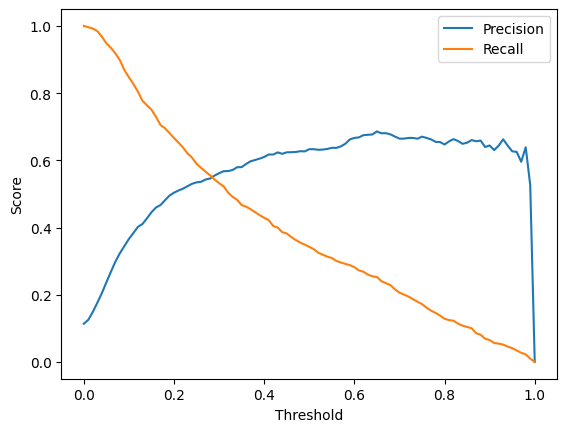

Порог, при котором пересекаются precision и recall: 0.28


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Диапазон порогов
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

# Вычисляем precision и recall для каждого порога
for threshold in thresholds:
    y_pred_threshold = (y_pred >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_pred_threshold, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_threshold))

# Построение графиков Precision и Recall
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

# Найдем порог, где precision и recall пересекаются
threshold_cross = None
for i, (p, r) in enumerate(zip(precisions, recalls)):
    if abs(p - r) < 0.01:
        threshold_cross = thresholds[i]
        break
print("Порог, при котором пересекаются precision и recall:", threshold_cross)


# Вопрос 4: F1 score
# Вычислим F1 score для всех порогов и найдем максимальный:

In [ ]:
f1_scores = []

for p, r in zip(precisions, recalls):
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)

# Определение порога с максимальным F1
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
print(f'Максимальный f1 score: {max_f1_threshold}')

0.2


# Вопрос 5: 5-кратная кросс-валидация
# Используем KFold для оценки модели:

In [ ]:
from sklearn.model_selection import KFold

# Инициализация KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []

for train_idx, val_idx in kf.split(df_train):
    train_data, val_data = df_train.iloc[train_idx], df_train.iloc[val_idx]
    train_dict = train_data.drop(columns=['y']).to_dict(orient='records')
    val_dict = val_data.drop(columns=['y']).to_dict(orient='records')
    
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)
    y_train = train_data['y'].values
    y_val = val_data['y'].values
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

# Стандартная ошибка
std_error = np.std(aucs)
print(f'Стандартная ошибка: {std_error}')

0.004092112681399903


# Вопрос 6: Тюнинг гиперпараметров
# Найдем лучшее значение C с помощью кросс-валидации:

In [ ]:
C_values = [0.000001, 0.001, 1]
mean_scores = []
std_scores = []

for C in C_values:
    aucs = []
    for train_idx, val_idx in kf.split(df_train):
        train_data, val_data = df_train.iloc[train_idx], df_train.iloc[val_idx]
        train_dict = train_data.drop(columns=['y']).to_dict(orient='records')
        val_dict = val_data.drop(columns=['y']).to_dict(orient='records')
        
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)
        y_train = train_data['y'].values
        y_val = val_data['y'].values
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    
    mean_scores.append(np.mean(aucs))
    std_scores.append(np.std(aucs))

# Определение лучшего значения C
best_index = np.argmax(mean_scores)
best_C = C_values[best_index]
print(f'Лучшее значение C: {best_C}, {round(mean_scores[best_index], 3)}, {round(std_scores[best_index], 3)}')


1 0.908 0.004
